In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break;

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cidaut-ai-fake-scene-classification-2024/sample_submission.csv
/kaggle/input/cidaut-ai-fake-scene-classification-2024/Test/473.jpg
/kaggle/input/cidaut-ai-fake-scene-classification-2024/Train/623.jpg


# EDA

In [3]:
import os


dataset_path = r'/kaggle/input/cidaut-ai-fake-scene-classification-2024'

n_train = len(os.listdir(os.path.join(dataset_path, 'Train')))
n_test = len(os.listdir(os.path.join(dataset_path, 'Test')))

print(f"Number of train samples: {n_train}")
print(f"Number of test samples: {n_test}")

Number of train samples: 720
Number of test samples: 180


In [4]:
import pandas as pd


sample_submission = pd.read_csv(os.path.join(dataset_path, 'sample_submission.csv'))
sample_submission.head()
sample_submission.groupby(['label']).size()/len(sample_submission)*100

label
0    48.888889
1    51.111111
dtype: float64

In [7]:
train_csv = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
print(train_csv.head())
print(train_csv.groupby(['label']).size()/len(train_csv)*100)

   image    label
0  1.jpg  editada
1  2.jpg     real
2  3.jpg     real
3  6.jpg  editada
4  8.jpg     real
label
editada    43.75
real       56.25
dtype: float64


In [29]:
# Do image visualization and other EDA here
from matplotlib import pyplot as plt
from PIL import Image
from pathlib import Path
import numpy as np

# View the average red, green, blue (Concept is to have equal distribution for train / val / test dataset)
base_dir = Path("/kaggle/input")
train_csv['height'] = 0  
train_csv['width'] = 0
train_csv['mean_rgb'] = 0

for index , row in train_csv.iterrows(): 
    filepath = os.path.join(base_dir , 'cidaut-ai-fake-scene-classification-2024' , 'Train' , row['image'])
    image = Image.open(filepath)
    width, height = image.size
    train_csv.loc[index , 'width'] = width 
    train_csv.loc[index , 'height'] = height
    train_csv.loc[index , 'mean_rgb'] = np.asarray(image).mean().astype(float)

<ipython-input-29-77d8af1b2d4a>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '46.917036313657405' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_csv.loc[index , 'mean_rgb'] = np.asarray(image).mean().astype(float)


In [33]:
train_csv.head()

,image,label,height,width,mean_rgb
0,1.jpg,editada,720,1280,46.917036
1,2.jpg,real,720,1280,143.557921
2,3.jpg,real,720,1280,86.876892
3,6.jpg,editada,720,1280,104.495748
4,8.jpg,real,720,1280,93.781969


<Axes: >

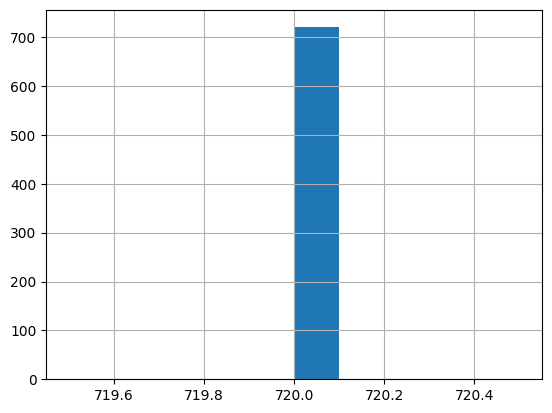

In [31]:
train_csv['height'].hist(grid=True)

<Axes: >

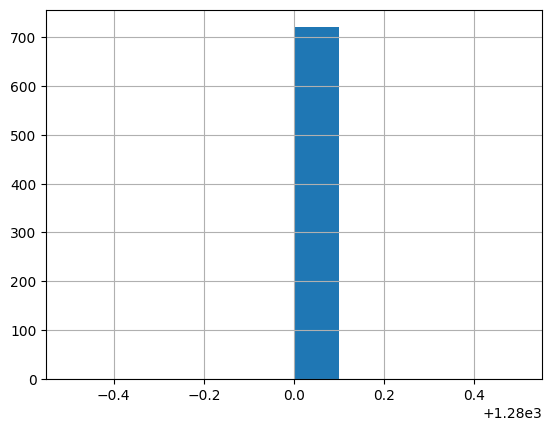

In [32]:
train_csv['width'].hist(grid=True)

<Axes: >

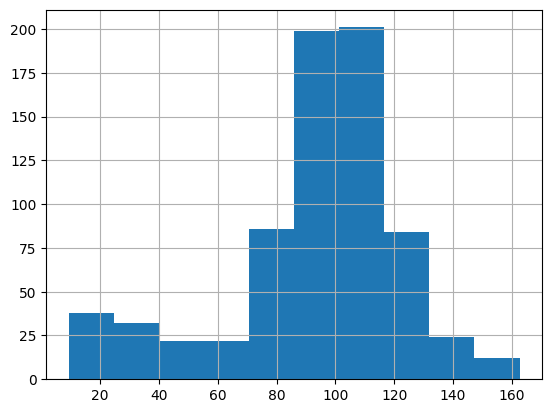

In [34]:
train_csv['mean_rgb'].hist(grid=True)

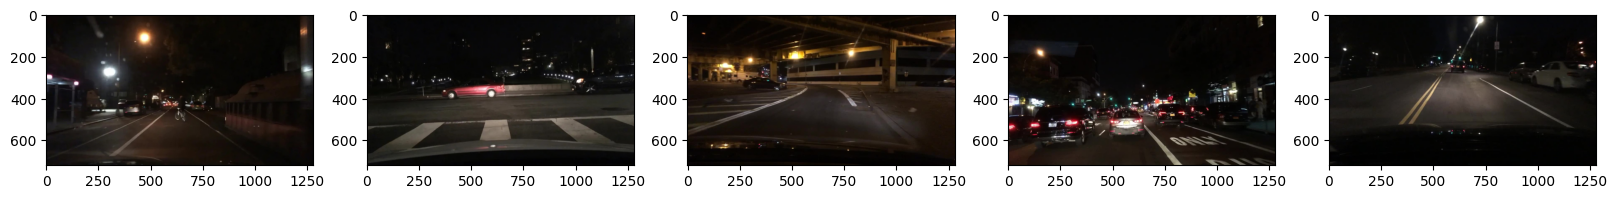

In [46]:
fig , ax  = plt.subplots( 1, 5 , figsize=(20, 20))

index = 0
for i , row in train_csv[train_csv['mean_rgb'] < 40].head().iterrows():
    filepath  = os.path.join(base_dir , 'cidaut-ai-fake-scene-classification-2024' , 'Train' , row['image'])
    image = Image.open(filepath)
    ax[index].imshow(image)
    index += 1

plt.show()

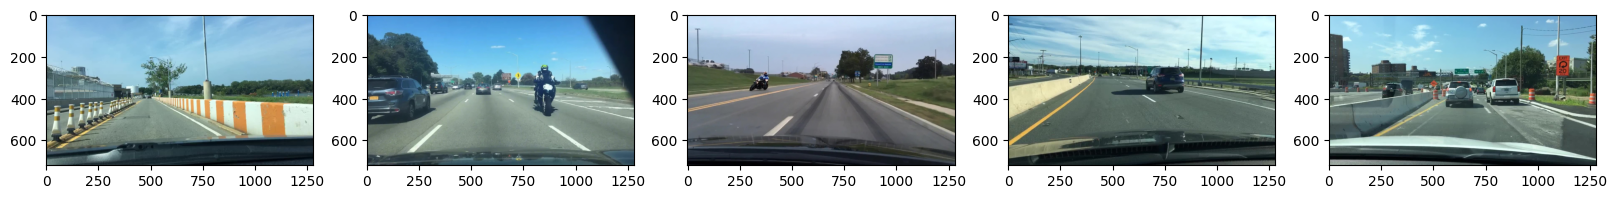

In [47]:
fig , ax  = plt.subplots( 1, 5 , figsize=(20, 20))

index = 0
for i , row in train_csv[train_csv['mean_rgb'] > 120].head().iterrows():
    filepath  = os.path.join(base_dir , 'cidaut-ai-fake-scene-classification-2024' , 'Train' , row['image'])
    image = Image.open(filepath)
    ax[index].imshow(image)
    index += 1

plt.show()

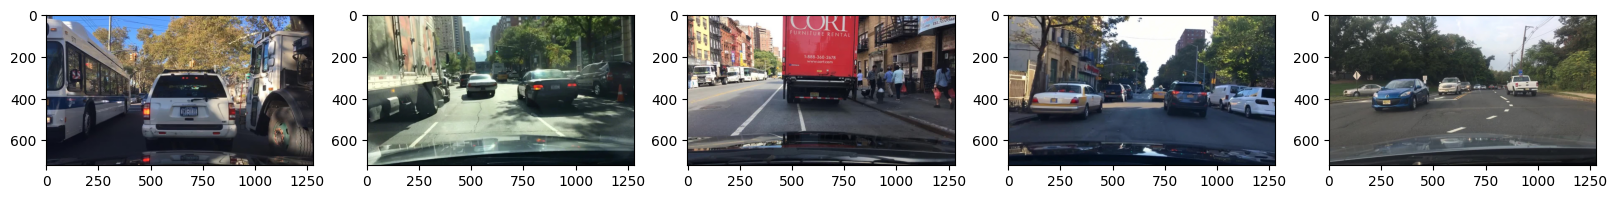

In [64]:
fig , ax  = plt.subplots( 1, 5 , figsize=(20, 20))

index = 0
for i , row in train_csv[(train_csv['mean_rgb'] < 120) & (train_csv['mean_rgb'] > 80)].head().iterrows():
    filepath  = os.path.join(base_dir , 'cidaut-ai-fake-scene-classification-2024' , 'Train' , row['image'])
    image = Image.open(filepath)
    ax[index].imshow(image)
    index += 1

plt.show()

# Data Preprocessing

In [61]:
from sklearn.model_selection import train_test_split

# sort by rgb 
train_csv_sorted = train_csv.sort_values(by='mean_rgb')
train_df , val_df = train_test_split(train_csv_sorted , test_size=0.3)
val_df , test_df = train_test_split(val_df , test_size=0.5)

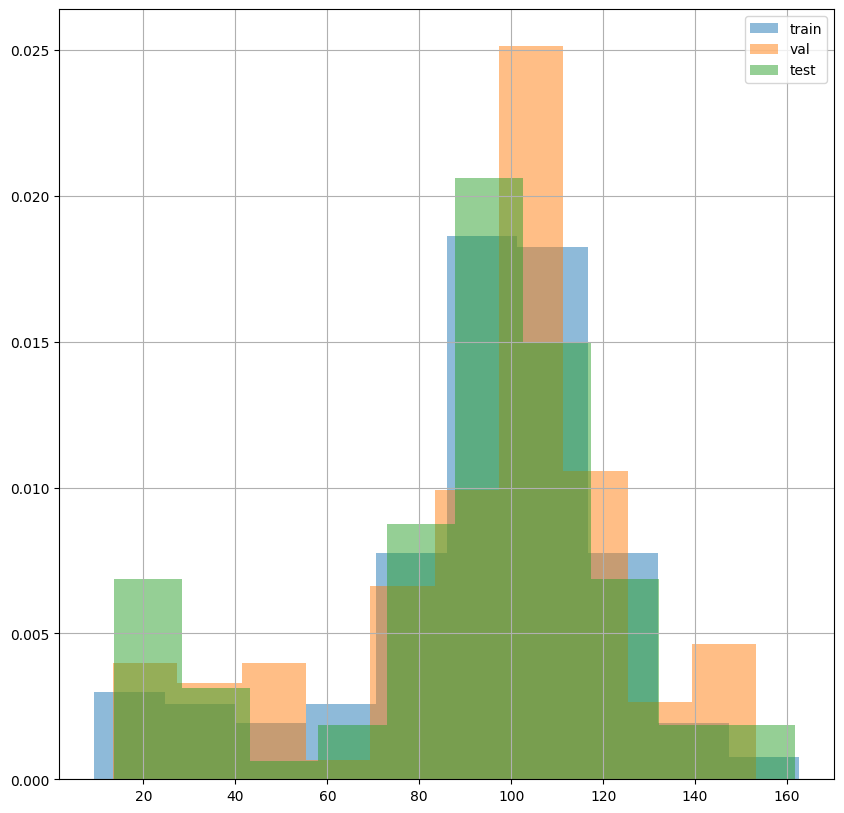

In [66]:
fig , ax = plt.subplots(1, 1, figsize=(10, 10))

train_df['mean_rgb'].hist(ax=ax , grid=True , density=True , alpha=0.5)
val_df['mean_rgb'].hist(ax=ax , grid=True , density=True , alpha=0.5)
test_df['mean_rgb'].hist(ax=ax, grid=True , density=True , alpha=0.5)
ax.legend(['train' , 'val' , 'test'])

# Model Training

# Inference \& Evaluation